In [1]:
(asdf:load-system :imago/jupyter)
(asdf:load-system :diff-boundary-corrfn)
(asdf:load-system :py4cl)

T

T

T

SB-KERNEL:REDEFINITION-WITH-DEFMETHOD: redefining VALIDATE-SUPERCLASS (#<STANDARD-CLASS ORG.TFEB.HAX.ABSTRACT-CLASSES:ABSTRACT-CLASS>
                                                                       #<STANDARD-CLASS COMMON-LISP:STANDARD-CLASS>) in DEFMETHOD
SB-KERNEL:REDEFINITION-WITH-DEFMETHOD: redefining VALIDATE-SUPERCLASS (#<STANDARD-CLASS COMMON-LISP:STANDARD-CLASS>
                                                                       #<STANDARD-CLASS ORG.TFEB.HAX.ABSTRACT-CLASSES:ABSTRACT-CLASS>) in DEFMETHOD
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining MAGICL::SVD-LISP in DEFUN
BAD-SYSTEM-NAME: System definition file #P"/home/vasily/.quicklisp/dists/ultralisp/software/hankhero-cl-json-20200326183916/cl-json.asd" contains definition for system "cl-json.test". Please only define "cl-json" and secondary systems with a name starting with "cl-json/" (e.g. "cl-json/test") in that file.


In [2]:
(load
  (asdf:system-relative-pathname :diff-boundary-corrfn
                                 #p"examples/functions.lisp"))

T

In [9]:
;; Create a function which sums values of 6 random bell-shaped curves
(defparameter *field*
  (example-functions:gaussian-field
    (example-functions:random-gaussians 6)))

*FIELD*

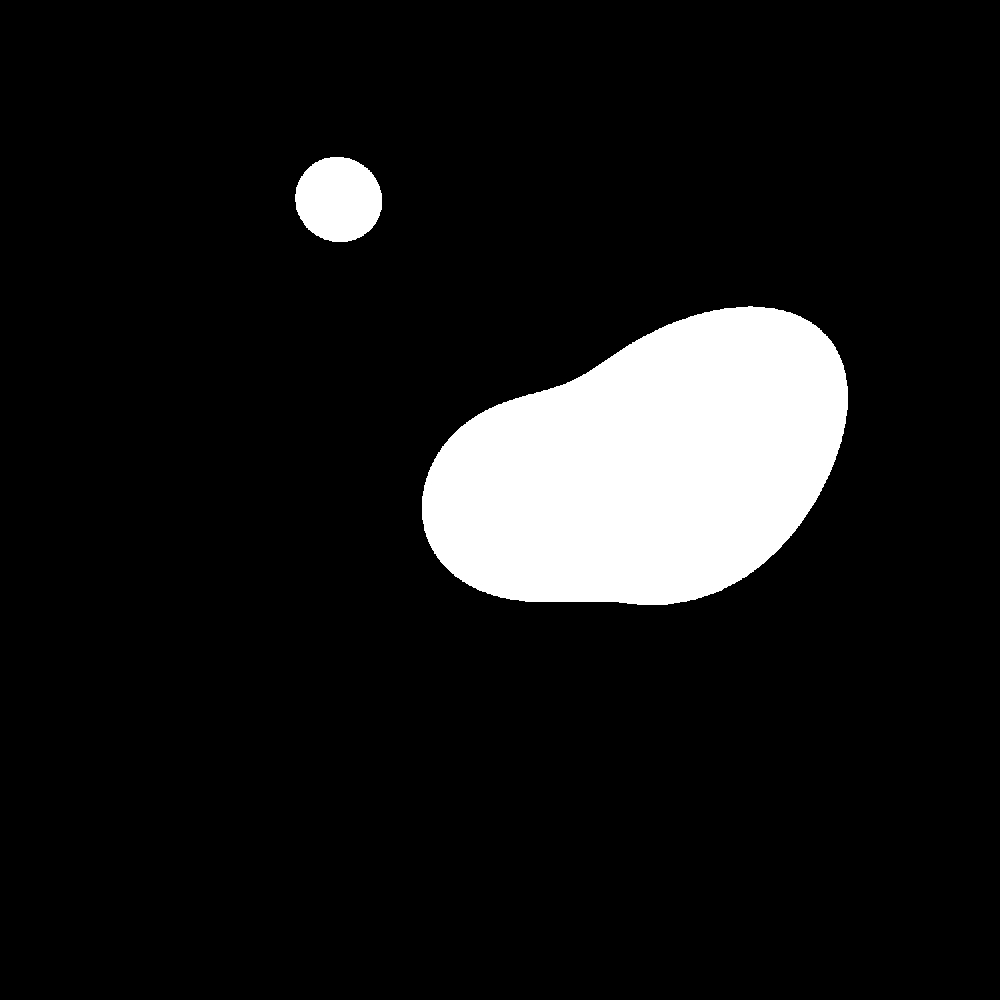

In [10]:
;; Evaluate it at points in uniform 3000x3000 grid and save an image
(let ((image (imago:make-binary-image-from-pixels
               (let ((descr (diff-boundary-corrfn:discretize-field 1500 2 *field*)))
                 (aops:vectorize* 'bit (descr) (if (> descr 5.0) 1 0))))))
  (imago:write-image image "/jails/julia/home/vasily/field.pbm")
  (imago-jupyter:show-image
    (imago:resize image 1000 1000)))

In [11]:
;; Calculate surface-surface function in a half-circle with radius R=0.1
;; Probably we need to disable division by zero trap because F_{ss} is ill-defined.
(defparameter *ss*
  (sb-int:with-float-traps-masked
    (:divide-by-zero)
    (let ((interface (diff-boundary-corrfn:interface *field* 2 5d0)))
      (diff-boundary-corrfn:surface2-at-dist interface 1d-1 150))))

*SS*

In [12]:
;; Remove points where F_{ss} is too big (close to points where it's undefined)
(defparameter *ss*
  (let ((ss (remove-if
              (lambda (x)
                (> (car x) 70))
              *ss*)))
    (make-array (list (length ss) 3)
                :element-type 'double-float
                :initial-contents ss)))

*SS*

In [13]:
(py4cl:import-module "matplotlib.pyplot" :as "plt")
(py4cl:import-module "numpy" :as "np")
(py4cl:import-module "scipy.interpolate" :as "inter")
(py4cl:import-function "slice")

T

T

T

SLICE

SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining PLT:ARROW in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining PLT:AXES in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining PLT:FIGURE in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining PLT:SUBPLOT in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining PLT:TEXT in DEFUN


In [14]:
;; Plot precisely calculated F_{ss} function
(plt:plot
  (np:arctan2
    (py4cl:chain *ss* (|[]| (slice 0 nil) 2))
    (py4cl:chain *ss* (|[]| (slice 0 nil) 1)))
  (py4cl:chain *ss* (|[]| (slice 0 nil) 0)))
(plt:show)

#(#S(PY4CL::PYTHON-OBJECT :TYPE "<class 'matplotlib.lines.Line2D'>" :HANDLE 3))

NIL

In [16]:
#|
Compare precisely calculated function with output of CorrelationFunctions.jl

In Julia you must do the following:
julia> import CorrelationFunctions.Map as M

julia> using Images

julia> using FileIO

julia> using FFTW

julia> using NPZ

julia> data = load("/home/vasily/field.pbm") |> BitArray;
WARNING: both ImageMetadata and ImageAxes export "data"; uses of it in module Images must be qualified

julia> size(data)
(1500, 1500)

julia> npzwrite("/home/vasily/field-ss.npy", fftshift(M.surfsurf(data, true; periodic = true) * 1500^2))
|#

(let* ((julia (np:load "/jails/julia/home/vasily/field-ss.npy"))
       (x (np:linspace -1.0 1.0 1500))
       (f (inter:regulargridinterpolator (list x x) julia))
       (angles (np:arctan2
                 (py4cl:chain *ss* (|[]| (slice 0 nil) 2))
                 (py4cl:chain *ss* (|[]| (slice 0 nil) 1)))))
  (plt:plot angles (py4cl:chain *ss* (|[]| (slice 0 nil) 0)))
  (plt:plot angles (py4cl:python-call f (py4cl:chain *ss* (|[]| (slice nil) (slice 1 nil)))))
  (plt:legend #("Precise" "Julia"))
  (plt:xlabel "$\\phi$")
  (plt:ylabel "$F_{ss}(0.1, \\phi)$")
  (plt:show))

NIL